## Introduction

After we're done with the [Pre-processing and Training Data Development](https://github.com/tvo10/DSCT/blob/main/First%20Capstone/afib_detection_feature_engineering.ipynb). We have 2 files:
1. 12 features and 1 label.
2. 22 features and 1 label.

We do not know which dataset will help us in yielding the high accuracy score yet. As a result, in this notebook, we will read in each file and apply different algorithms to compare the accuracy score. Besides the accuracy metric, we also focus on the recall metric since we want to detect as many Atrial Fibrillation cases as possible.

In [7]:
#!pip install bayesian-optimization

In [1]:
# import essential libraries
import pandas as pd
import numpy as np
import pickle
import scipy
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegressionCV, SGDClassifier, RidgeClassifier
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, mean_absolute_error, f1_score
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import svm, linear_model
from sklearn import tree, metrics
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
import lightgbm
from bayes_opt import BayesianOptimization
from catboost import CatBoostClassifier, cv, Pool
import gzip

## (1) 11 Features and 1 Label

**10 Features:**
* age
* sex
* height
* weight
* heart_axis
* validated_by
* second_opinion
* validated_by_human
* pacemaker
* strat_fold

**1 Label:**
* ritmi

This csv file consists of 1803 observations and 11 variables. In brief, we already dropped the missing values for the height and weight columns.

In [4]:
# read in csv 
df = pd.read_csv('data/training_11_features.csv')
df = df.dropna()
# df = df[df['ritmi'] != 0]
df = df.reset_index(drop=True)
print(df.shape)
df.head()

(1803, 11)


,ritmi,age,sex,height,weight,heart_axis,validated_by,second_opinion,validated_by_human,pacemaker,strat_fold
0,2,29.0,1,164.0,56.0,0,0.0,0,1,0,1
1,0,59.0,0,156.0,75.0,0,0.0,0,1,0,9
2,2,84.0,1,152.0,51.0,0,0.0,0,1,0,7
3,0,79.0,0,172.0,66.0,0,0.0,0,1,0,5
4,1,67.0,0,178.0,73.0,4,0.0,0,1,0,5


In [5]:
# convert all columns' types to int64
df['age'] = df['age'].astype('int64')
df['height'] = df['height'].astype('int64')
df['weight'] = df['weight'].astype('int64')
df['validated_by'] = df['validated_by'].astype('int64')

# get info for columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1803 entries, 0 to 1802
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   ritmi               1803 non-null   int64
 1   age                 1803 non-null   int64
 2   sex                 1803 non-null   int64
 3   height              1803 non-null   int64
 4   weight              1803 non-null   int64
 5   heart_axis          1803 non-null   int64
 6   validated_by        1803 non-null   int64
 7   second_opinion      1803 non-null   int64
 8   validated_by_human  1803 non-null   int64
 9   pacemaker           1803 non-null   int64
 10  strat_fold          1803 non-null   int64
dtypes: int64(11)
memory usage: 155.1 KB


In [6]:
# train-test split
X = df.drop(columns='ritmi')
y = df['ritmi']
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size = 0.25, random_state = 246)

### Random Forest

We used the RandomForest algorithm and tuned the model with GridSearchCV, we got 0.45 for the highest performance score (accuracy metric). Afterwards, we used the model to predict X_test. Based on the recall metric, we can conclude that the model has 47% of accurately detecting normal cases, 41% of accurately detecting Atrial Fibrillation, and 49% of accurately detecting other arrhythmia cases.

In [7]:
# Plug in appropriate max_depth and random_state parameters
rf = RandomForestClassifier()
rf_param_grid = {'n_estimators': [600], 'criterion': ['entropy'], 'max_depth': [60]} #0.4615443314230772
rf_cv= GridSearchCV(rf,rf_param_grid,cv=7,n_jobs=-1)
rf_cv.fit(X_train,y_train)

print("Best Score:" + str(rf_cv.best_score_))
print("Best Parameters: " + str(rf_cv.best_params_))

Best Score:0.4556304226727815
Best Parameters: {'criterion': 'entropy', 'max_depth': 60, 'n_estimators': 600}


In [8]:
y_pred = rf_cv.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.42      0.42       162
           1       0.43      0.39      0.41       117
           2       0.45      0.47      0.46       172

    accuracy                           0.43       451
   macro avg       0.43      0.43      0.43       451
weighted avg       0.43      0.43      0.43       451



### LightGBM

We also used the LightGBM algorithm, and tuned the model with BayesianOptimization, and we got 0.64 for the highest performance score using the auc metric. We can say that the score has been improved a lot, but it is a different metric. Since the metric is not the same, we'll apply other algorithms later to see if there is another algorithm that helps improve our accuracy score.

In [9]:
def lgb_eval(num_leaves,max_depth,lambda_l2,lambda_l1,min_child_samples, min_data_in_leaf):
    params = {
        "objective" : "binary",
        "metric" : "auc", 
        'is_unbalance': True,
        "num_leaves" : int(num_leaves),
        "max_depth" : int(max_depth),
        "lambda_l2" : lambda_l2,
        "lambda_l1" : lambda_l1,
        "num_threads" : 20,
        "min_child_samples" : int(min_child_samples),
        'min_data_in_leaf': int(min_data_in_leaf),
        "learning_rate" : 0.03,
        "subsample_freq" : 5,
        "bagging_seed" : 42,
        "verbosity" : -1
    }
    lgtrain = lightgbm.Dataset(X_train, y_train)
    cv_result = lightgbm.cv(params,
                       lgtrain,
                       1000,
                       early_stopping_rounds=100,
                       stratified=True,
                       nfold=3)
    return cv_result['auc-mean'][-1]

In [10]:
lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (25, 4000),
                                                'max_depth': (5, 63),
                                                'lambda_l2': (0.0, 0.05),
                                                'lambda_l1': (0.0, 0.05),
                                                'min_child_samples': (50, 10000),
                                                'min_data_in_leaf': (100, 2000)
                                                })

lgbBO.maximize(n_iter=10, init_points=2)

|   iter    |  target   | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_da... | num_le... |
-------------------------------------------------------------------------------------------------
[LightGBM] [Warning] min_data_in_leaf is set=706, min_child_samples=5146 will be ignored. Current value: min_data_in_leaf=706
|  1        |  0.5      |  0.03421  |  0.03484  |  37.72    |  5.147e+0 |  706.2    |  2.977e+0 |
|  2        |  0.5      |  0.03634  |  0.01601  |  12.18    |  7.838e+0 |  1.158e+0 |  1.128e+0 |
|  3        |  0.5      |  0.01488  |  0.01509  |  34.57    |  1.306e+0 |  984.6    |  2.978e+0 |
|  4        |  0.5      |  0.04356  |  0.02226  |  22.41    |  9.981e+0 |  1.823e+0 |  3.955e+0 |
|  5        |  0.6392   |  0.04484  |  0.01282  |  22.19    |  9.978e+0 |  188.4    |  400.8    |
|  6        |  0.5      |  0.0467   |  0.01057  |  44.16    |  4.907e+0 |  1.443e+0 |  606.2    |
|  7        |  0.5      |  0.017    |  0.001409 |  12.41    |  4.434e+0 |  685.2    |  3.4

### Other Algorithms

After trying different algorithms, we can see that KNeighborsClassifier returned 0.45 for the highest score using the same accuracy metric. Based on the recall metric, the model has 41% of accurately detecting normal cases, 47% of accurately detecting Atrial Fibrillation, and 49% of accurately detecting other arrhythmia cases. Even though it has more percentage of detecting Atrial Fibrillation cases, the accuracy score is lower than using the Random Forest algorithm. However, we can assume that KNeighborsClassifier is the most suitable algorithm in this dataset.

In [12]:
# clfl2=LogisticRegression(max_iter=1000000)
# parameters = {'C': [10000], 'solver': ['saga'],  'multi_class': ['auto']} # 0.4681891485581523

# clfl2 = svm.SVC()
# parameters = {'kernel':['linear'], 'C':[8]} #0.45558562252289186

# clfl2 = LogisticRegressionCV(max_iter=100000)
# parameters = {"Cs": [10], 'solver': ['saga'], 'fit_intercept':[True], 'penalty': ['l1']} # 0.4711466447997813

# clfl2 = RidgeClassifier(max_iter=1000)
# parameters = {'alpha': [0.9], 'solver': ['auto']} #0.4592865928659286

clfl2 = KNeighborsClassifier()
parameters = {'n_neighbors': [150], 'weights': ['distance'], 'metric': ['euclidean']} #0.4889326226595599

fitmodel = GridSearchCV(clfl2, param_grid=parameters, cv=5, refit=True, scoring="accuracy", n_jobs=-1, verbose=3)
fitmodel.fit(X_train, y_train)
print(fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
KNeighborsClassifier(metric='euclidean', n_neighbors=150, weights='distance') {'metric': 'euclidean', 'n_neighbors': 150, 'weights': 'distance'} 0.48745114117807836


In [13]:
y_pred = fitmodel.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.40      0.43       162
           1       0.48      0.47      0.48       117
           2       0.42      0.49      0.45       172

    accuracy                           0.45       451
   macro avg       0.46      0.45      0.45       451
weighted avg       0.45      0.45      0.45       451



## (2) 13 Features and 1 Label

**13 Features:**
* age
* sex
* height
* weight
* nurse
* site
* device
* heart_axis
* validated_by
* second_opinion
* validated_by_human
* pacemaker
* strat_fold

**1 Label:** 
* ritmi

This csv file consists of 6366 observations and 14 variables. Insread of dropping missing values for the columns, we filled the missing values with the mean values for the age, height, and weight columns. In addition, we also filled the missing values with 0 for the nurse, site, validated_by, heart_axis, and pacemaker columns.

In [14]:
df = pd.read_csv('data/training_13_features.csv')
new_df = df.dropna()
# new_df = new_df[new_df['ritmi'] != 2]
new_df = new_df.reset_index(drop=True)
df.head()

,ritmi,age,sex,height,weight,nurse,site,device,heart_axis,validated_by,second_opinion,validated_by_human,pacemaker,strat_fold
0,2,54.0,0,166.796356,69.841845,0.0,0.0,0,3.0,0.0,0,0,0.0,6
1,1,54.0,0,166.796356,69.841845,0.0,0.0,0,3.0,0.0,0,0,0.0,6
2,0,55.0,0,166.796356,69.841845,1.0,2.0,1,1.0,1.0,0,1,0.0,10
3,2,29.0,1,164.000000,56.000000,7.0,1.0,10,0.0,0.0,0,1,0.0,1
4,2,57.0,0,166.796356,69.841845,0.0,0.0,0,3.0,0.0,0,0,0.0,1


In [15]:
# convert all columns' types to float64
for i in range(14):
    new_df[new_df.columns[i]] = new_df[new_df.columns[i]].astype('float64')
    
# get info for columns
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6366 entries, 0 to 6365
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ritmi               6366 non-null   float64
 1   age                 6366 non-null   float64
 2   sex                 6366 non-null   float64
 3   height              6366 non-null   float64
 4   weight              6366 non-null   float64
 5   nurse               6366 non-null   float64
 6   site                6366 non-null   float64
 7   device              6366 non-null   float64
 8   heart_axis          6366 non-null   float64
 9   validated_by        6366 non-null   float64
 10  second_opinion      6366 non-null   float64
 11  validated_by_human  6366 non-null   float64
 12  pacemaker           6366 non-null   float64
 13  strat_fold          6366 non-null   float64
dtypes: float64(14)
memory usage: 696.4 KB


In [16]:
# train-test split
X = new_df.drop(columns='ritmi')
y = new_df['ritmi']
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size = 0.2, random_state = 246)

### Random Forest

We used the RandomForest algorithm and tuned the model with GridSearchCV, we got 0.50 for the accuracy score. Afterwards, we used the model to predict X_test. Based on the recall metric, we can conclude that the model has 38% of accurately detecting normal cases, 49% of accurately detecting Atrial Fibrillation, and 60% of accurately detecting other arrhythmia cases.

In [17]:
# Plug in appropriate max_depth and random_state parameters
rf = RandomForestClassifier()
rf_param_grid = {'n_estimators': [600], 'criterion': ['entropy'], 'max_depth': [60]} #0.502161524857536
rf_cv= GridSearchCV(rf,rf_param_grid,cv=7,n_jobs=-1)
rf_cv.fit(X_train,y_train)

print("Best Score:" + str(rf_cv.best_score_))
print("Best Parameters: " + str(rf_cv.best_params_))

Best Score:0.5037305738081922
Best Parameters: {'criterion': 'entropy', 'max_depth': 60, 'n_estimators': 600}


In [18]:
y_pred = rf_cv.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.43      0.38      0.40       407
         1.0       0.51      0.49      0.50       318
         2.0       0.53      0.59      0.56       549

    accuracy                           0.50      1274
   macro avg       0.49      0.49      0.49      1274
weighted avg       0.49      0.50      0.50      1274



### LightGBM

We also used the LightGBM algorithm, and tuned the model with BayesianOptimization, and we got 0.64 for the highest performance score using the auc metric.

In [21]:
lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (25, 4000),
                                                'max_depth': (5, 63),
                                                'lambda_l2': (0.0, 0.05),
                                                'lambda_l1': (0.0, 0.05),
                                                'min_child_samples': (50, 10000),
                                                'min_data_in_leaf': (100, 2000)
                                                })

lgbBO.maximize(n_iter=10, init_points=3)

|   iter    |  target   | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_da... | num_le... |
-------------------------------------------------------------------------------------------------
|  1        |  0.5      |  0.04576  |  0.02804  |  10.88    |  3.772e+0 |  1.742e+0 |  1.617e+0 |
|  2        |  0.6276   |  0.01505  |  0.04575  |  19.97    |  1.794e+0 |  644.3    |  3.921e+0 |
|  3        |  0.6234   |  0.04788  |  0.005692 |  10.51    |  6.829e+0 |  986.9    |  1.6e+03  |
|  4        |  0.634    |  0.03227  |  0.0063   |  62.33    |  8.838e+0 |  310.1    |  1.531e+0 |
|  5        |  0.6272   |  0.00381  |  0.03482  |  46.63    |  1.995e+0 |  813.2    |  2.481e+0 |
|  6        |  0.5      |  0.04047  |  0.002953 |  48.13    |  770.6    |  1.865e+0 |  390.6    |
|  7        |  0.6358   |  0.02262  |  0.01014  |  34.94    |  8.93e+03 |  266.1    |  1.618e+0 |
|  8        |  0.632    |  0.0226   |  0.0142   |  62.36    |  8.191e+0 |  515.0    |  3.741e+0 |
|  9        |  0.5  

### K-Neighbors

Finally, we applied the KNeighborsClassifier algorithm. Based on the recall metric, the model has 23% of accurately detecting normal cases, 40% of accurately detecting Atrial Fibrillation, and 70% of accurately detecting other arrhythmia cases. Thus, we can conclude that RandomForest works best for this dataset as it returns 0.5 as the accuracy score and it has 49% of accurately detecting Atrial Fibrillation cases.

In [22]:
clfl2 = KNeighborsClassifier()
parameters = {'n_neighbors': [140], 'weights': ['distance'], 'metric': ['euclidean']} #0.4830258302583026

fitmodel = GridSearchCV(clfl2, param_grid=parameters, cv=5, refit=True, scoring="accuracy", n_jobs=-1, verbose=2)
fitmodel.fit(X_train, y_train)
print(fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
KNeighborsClassifier(metric='euclidean', n_neighbors=140, weights='distance') {'metric': 'euclidean', 'n_neighbors': 140, 'weights': 'distance'} 0.481932284627442


In [23]:
y_pred = fitmodel.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.38      0.23      0.29       407
         1.0       0.54      0.41      0.46       318
         2.0       0.49      0.69      0.57       549

    accuracy                           0.47      1274
   macro avg       0.47      0.44      0.44      1274
weighted avg       0.46      0.47      0.45      1274



## (3) 22 Features and 1 Label

**22 Features:**
* I
* II
* III
* aVF
* aVR
* aVL
* V1
* V2
* V3
* V4
* V5
* V6
* age
* sex
* height
* weight
* device
* heart_axis
* validated_by
* second_opinion
* validated_by_human
* pacemaker

**1 Label:**
* ritmi

This dataset consists of 4319176 observations and 26 variables. This dataset is different than the other two datasets since we combined 12 variables in the compressed numpy data file and 14 variables in the second dataset. Therefore, we have more information about the 12 ecg leads that may help us in detecting atrial fibrillation cases.

In [2]:
# read in csv
df = pd.read_csv('data/training_25_features.csv')
df

,I,II,III,aVF,aVR,aVL,V1,V2,V3,V4,...,weight,nurse,site,device,heart_axis,validated_by,second_opinion,validated_by_human,pacemaker,strat_fold
0,-0.005,0.135,0.140,-0.065,-0.073,0.137,-0.125,-0.090,-0.110,-0.210,...,69.841845,0.0,0.0,0,3.0,0.0,0,0,0.0,6
1,-0.005,0.135,0.140,-0.065,-0.073,0.137,-0.125,-0.090,-0.110,-0.211,...,69.841845,0.0,0.0,0,3.0,0.0,0,0,0.0,6
2,-0.005,0.131,0.136,-0.063,-0.070,0.133,-0.125,-0.082,-0.102,-0.190,...,69.841845,0.0,0.0,0,3.0,0.0,0,0,0.0,6
3,-0.005,0.130,0.135,-0.063,-0.070,0.132,-0.122,-0.077,-0.094,-0.172,...,69.841845,0.0,0.0,0,3.0,0.0,0,0,0.0,6
4,-0.005,0.128,0.133,-0.062,-0.069,0.130,-0.119,-0.071,-0.084,-0.157,...,69.841845,0.0,0.0,0,3.0,0.0,0,0,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4319171,0.010,0.170,0.160,-0.090,-0.075,0.165,0.155,0.365,0.230,0.030,...,69.841845,1.0,2.0,1,3.0,1.0,0,1,0.0,8
4319172,0.014,0.174,0.160,-0.094,-0.073,0.167,0.155,0.368,0.245,0.029,...,69.841845,1.0,2.0,1,3.0,1.0,0,1,0.0,8
4319173,0.016,0.176,0.160,-0.096,-0.073,0.167,0.155,0.383,0.261,0.040,...,69.841845,1.0,2.0,1,3.0,1.0,0,1,0.0,8
4319174,0.014,0.174,0.160,-0.094,-0.073,0.167,0.155,0.406,0.282,0.059,...,69.841845,1.0,2.0,1,3.0,1.0,0,1,0.0,8


In [13]:
df

,I,II,III,aVF,aVR,aVL,V1,V2,V3,V4,...,age,sex,height,weight,device,heart_axis,validated_by,second_opinion,validated_by_human,pacemaker
0,-0.005,0.135,0.140,-0.065,-0.073,0.137,-0.125,-0.090,-0.110,-0.210,...,54.0,0.0,166.796356,69.841845,0.0,3.0,0.0,0.0,0.0,0.0
1,-0.005,0.135,0.140,-0.065,-0.073,0.137,-0.125,-0.090,-0.110,-0.211,...,54.0,0.0,166.796356,69.841845,0.0,3.0,0.0,0.0,0.0,0.0
2,-0.005,0.131,0.136,-0.063,-0.070,0.133,-0.125,-0.082,-0.102,-0.190,...,54.0,0.0,166.796356,69.841845,0.0,3.0,0.0,0.0,0.0,0.0
3,-0.005,0.130,0.135,-0.063,-0.070,0.132,-0.122,-0.077,-0.094,-0.172,...,54.0,0.0,166.796356,69.841845,0.0,3.0,0.0,0.0,0.0,0.0
4,-0.005,0.128,0.133,-0.062,-0.069,0.130,-0.119,-0.071,-0.084,-0.157,...,54.0,0.0,166.796356,69.841845,0.0,3.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4319171,0.010,0.170,0.160,-0.090,-0.075,0.165,0.155,0.365,0.230,0.030,...,27.0,0.0,166.796356,69.841845,1.0,3.0,1.0,0.0,1.0,0.0
4319172,0.014,0.174,0.160,-0.094,-0.073,0.167,0.155,0.368,0.245,0.029,...,27.0,0.0,166.796356,69.841845,1.0,3.0,1.0,0.0,1.0,0.0
4319173,0.016,0.176,0.160,-0.096,-0.073,0.167,0.155,0.383,0.261,0.040,...,27.0,0.0,166.796356,69.841845,1.0,3.0,1.0,0.0,1.0,0.0
4319174,0.014,0.174,0.160,-0.094,-0.073,0.167,0.155,0.406,0.282,0.059,...,27.0,0.0,166.796356,69.841845,1.0,3.0,1.0,0.0,1.0,0.0


In [3]:
# convert all the columns to float64
# df = df.drop(['nurse','site','strat_fold'],axis='columns')

for i in range(23):
    df[df.columns[i]] = df[df.columns[i]].astype('float64')
    
# get info for columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4319176 entries, 0 to 4319175
Data columns (total 26 columns):
 #   Column              Dtype  
---  ------              -----  
 0   I                   float64
 1   II                  float64
 2   III                 float64
 3   aVF                 float64
 4   aVR                 float64
 5   aVL                 float64
 6   V1                  float64
 7   V2                  float64
 8   V3                  float64
 9   V4                  float64
 10  V5                  float64
 11  V6                  float64
 12  ritmi               float64
 13  age                 float64
 14  sex                 float64
 15  height              float64
 16  weight              float64
 17  nurse               float64
 18  site                float64
 19  device              float64
 20  heart_axis          float64
 21  validated_by        float64
 22  second_opinion      float64
 23  validated_by_human  int64  
 24  pacemaker           floa

In [17]:
# train-test split
X = df.drop(columns='ritmi')
y = df['ritmi']
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size = 0.25, random_state = 1234)

### Random Forest

After training and tuning the model for the second dataset, we learned that the Random Forest algorithm is the best for detecting Atrial Fibrillation cases. Since this dataset is based off the second dataset (please see [here](https://github.com/tvo10/DSCT/blob/main/First%20Capstone/afib_detection_feature_engineering.ipynb) for further details), we only applied the Random Forest algorithm to get the accuracy score. Surprisingly, we got **0.99** for the accuracy score. We can conclude that the third dataset is the best dataset among the three datasets. Based on the recall metric, the model has 99% of accurately detecting normal cases, 98% of accurately detecting Atrial Fibrillation cases, and 99% of accurately detecting other arrhythmia cases.

In [ ]:
clfl2 = KNeighborsClassifier()
parameters = {'n_neighbors': [140], 'weights': ['distance'], 'metric': ['euclidean']} #0.4830258302583026

fitmodel = GridSearchCV(clfl2, param_grid=parameters, cv=5, refit=True, scoring="accuracy", n_jobs=-1, verbose=2)
fitmodel.fit(X_train, y_train)
print(fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [19]:
# Plug in appropriate max_depth and random_state parameters
import time
print(time.ctime(time.time()))
rf = RandomForestClassifier()
# rf_param_grid = {'n_estimators': [20], 'criterion': ['entropy'], 'max_depth': [20]} #0.9267653536506913
rf_param_grid = {'n_estimators': [45], 'criterion': ['entropy'], 'max_depth': [45]} #0.9868391563552115
rf_cv= GridSearchCV(rf,rf_param_grid,cv=7,n_jobs=-1)
rf_cv.fit(X_train,y_train)
print(time.ctime(time.time()))

print("Best Score:" + str(rf_cv.best_score_))
print("Best Parameters: " + str(rf_cv.best_params_))

Sun Oct 23 13:24:39 2022
Sun Oct 23 14:09:18 2022
Best Score:0.9779448673026835
Best Parameters: {'criterion': 'entropy', 'max_depth': 45, 'n_estimators': 45}


In [20]:
import winsound

# frequency is set to 500Hz
freq = 1000

# duration is set to 100 milliseconds
dur = 1000
winsound.Beep(freq, dur)


In [21]:
winsound.Beep(freq, 1000)

# Only ECG features - 1 Label

In [5]:
# read in csv
df = pd.read_csv('data/training_25_features.csv')
df

,I,II,III,aVF,aVR,aVL,V1,V2,V3,V4,...,weight,nurse,site,device,heart_axis,validated_by,second_opinion,validated_by_human,pacemaker,strat_fold
0,-0.005,0.135,0.140,-0.065,-0.073,0.137,-0.125,-0.090,-0.110,-0.210,...,69.841845,0.0,0.0,0,3.0,0.0,0,0,0.0,6
1,-0.005,0.135,0.140,-0.065,-0.073,0.137,-0.125,-0.090,-0.110,-0.211,...,69.841845,0.0,0.0,0,3.0,0.0,0,0,0.0,6
2,-0.005,0.131,0.136,-0.063,-0.070,0.133,-0.125,-0.082,-0.102,-0.190,...,69.841845,0.0,0.0,0,3.0,0.0,0,0,0.0,6
3,-0.005,0.130,0.135,-0.063,-0.070,0.132,-0.122,-0.077,-0.094,-0.172,...,69.841845,0.0,0.0,0,3.0,0.0,0,0,0.0,6
4,-0.005,0.128,0.133,-0.062,-0.069,0.130,-0.119,-0.071,-0.084,-0.157,...,69.841845,0.0,0.0,0,3.0,0.0,0,0,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4319171,0.010,0.170,0.160,-0.090,-0.075,0.165,0.155,0.365,0.230,0.030,...,69.841845,1.0,2.0,1,3.0,1.0,0,1,0.0,8
4319172,0.014,0.174,0.160,-0.094,-0.073,0.167,0.155,0.368,0.245,0.029,...,69.841845,1.0,2.0,1,3.0,1.0,0,1,0.0,8
4319173,0.016,0.176,0.160,-0.096,-0.073,0.167,0.155,0.383,0.261,0.040,...,69.841845,1.0,2.0,1,3.0,1.0,0,1,0.0,8
4319174,0.014,0.174,0.160,-0.094,-0.073,0.167,0.155,0.406,0.282,0.059,...,69.841845,1.0,2.0,1,3.0,1.0,0,1,0.0,8


In [4]:
dfecg = df[['I', 'II', 'III', 'aVF', 'aVR', 'aVL', 'V1', 'V2', 'V3', 'V4', 'V5','V6','ritmi']]
dfecg

,I,II,III,aVF,aVR,aVL,V1,V2,V3,V4,V5,V6,ritmi
0,-0.005,0.135,0.140,-0.065,-0.073,0.137,-0.125,-0.090,-0.110,-0.210,-0.145,-0.080,2.0
1,-0.005,0.135,0.140,-0.065,-0.073,0.137,-0.125,-0.090,-0.110,-0.211,-0.146,-0.080,2.0
2,-0.005,0.131,0.136,-0.063,-0.070,0.133,-0.125,-0.082,-0.102,-0.190,-0.129,-0.072,2.0
3,-0.005,0.130,0.135,-0.063,-0.070,0.132,-0.122,-0.077,-0.094,-0.172,-0.116,-0.067,2.0
4,-0.005,0.128,0.133,-0.062,-0.069,0.130,-0.119,-0.071,-0.084,-0.157,-0.102,-0.061,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4319171,0.010,0.170,0.160,-0.090,-0.075,0.165,0.155,0.365,0.230,0.030,-0.065,-0.060,0.0
4319172,0.014,0.174,0.160,-0.094,-0.073,0.167,0.155,0.368,0.245,0.029,-0.057,-0.056,0.0
4319173,0.016,0.176,0.160,-0.096,-0.073,0.167,0.155,0.383,0.261,0.040,-0.052,-0.055,0.0
4319174,0.014,0.174,0.160,-0.094,-0.073,0.167,0.155,0.406,0.282,0.059,-0.046,-0.053,0.0


In [5]:
# train-test split
X = dfecg.drop(columns='ritmi')
y = df['ritmi']
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size = 0.25, random_state = 1234)

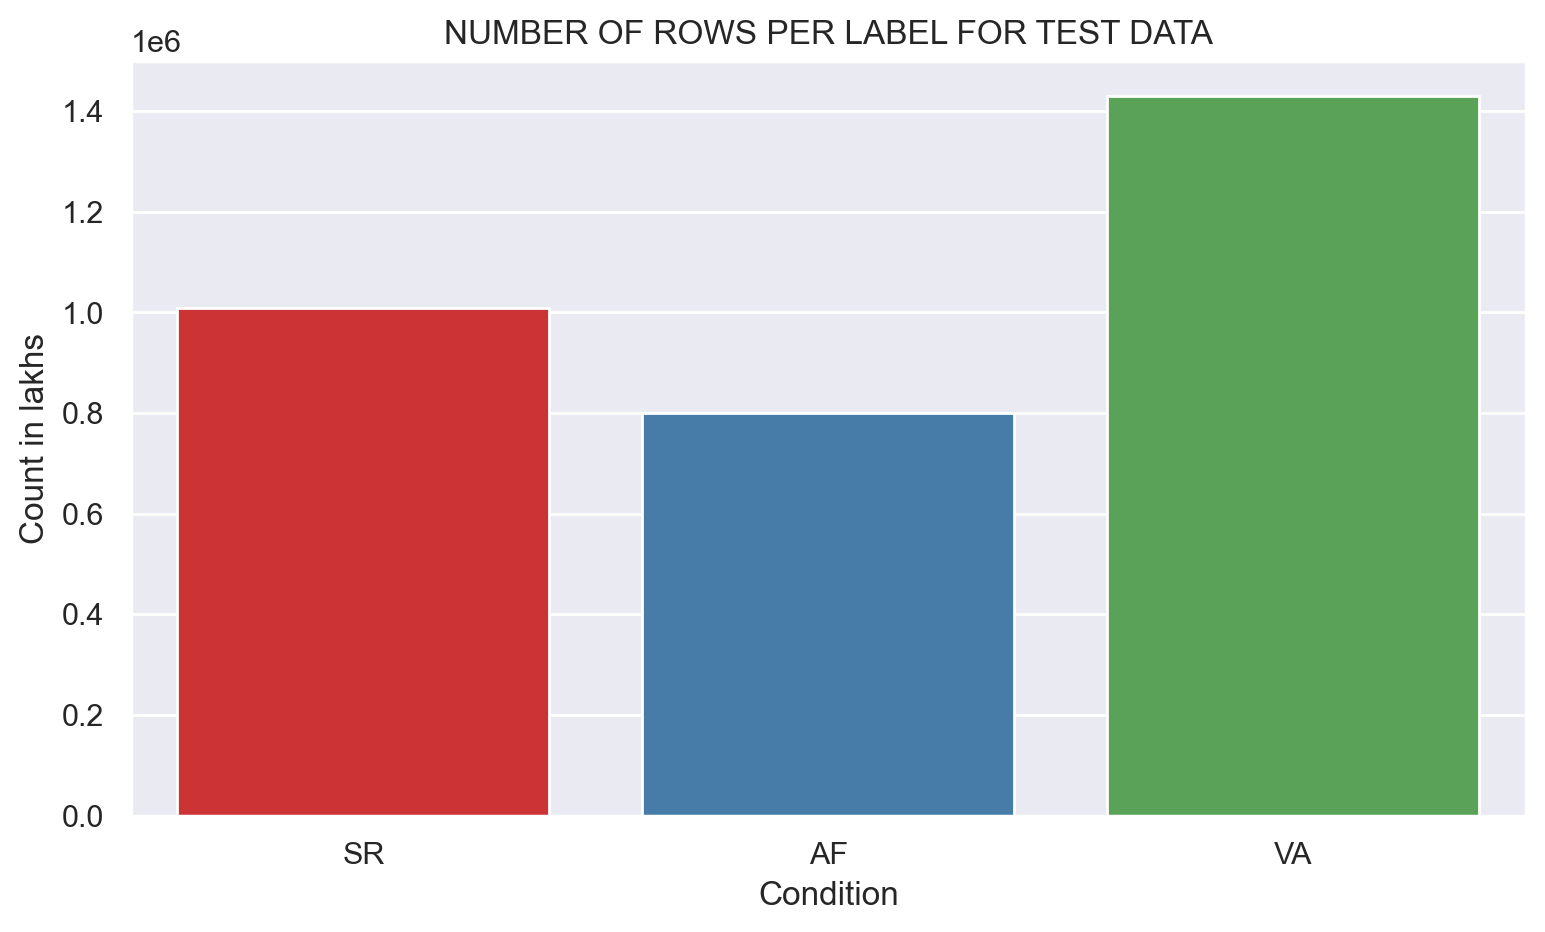

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
# countplot for diagnosi column
test = pd.DataFrame({'ritmi':list(y_train)})
sns.set(rc={'figure.figsize':(9,5),"figure.dpi":200})
g = sns.countplot(x='ritmi', data=test, palette='Set1')
g.set(xticklabels=["SR", "AF", "VA"])
plt.xlabel('Condition')
plt.ylabel('Count in lakhs')
plt.title('NUMBER OF ROWS PER LABEL FOR TEST DATA')
plt.show(g)

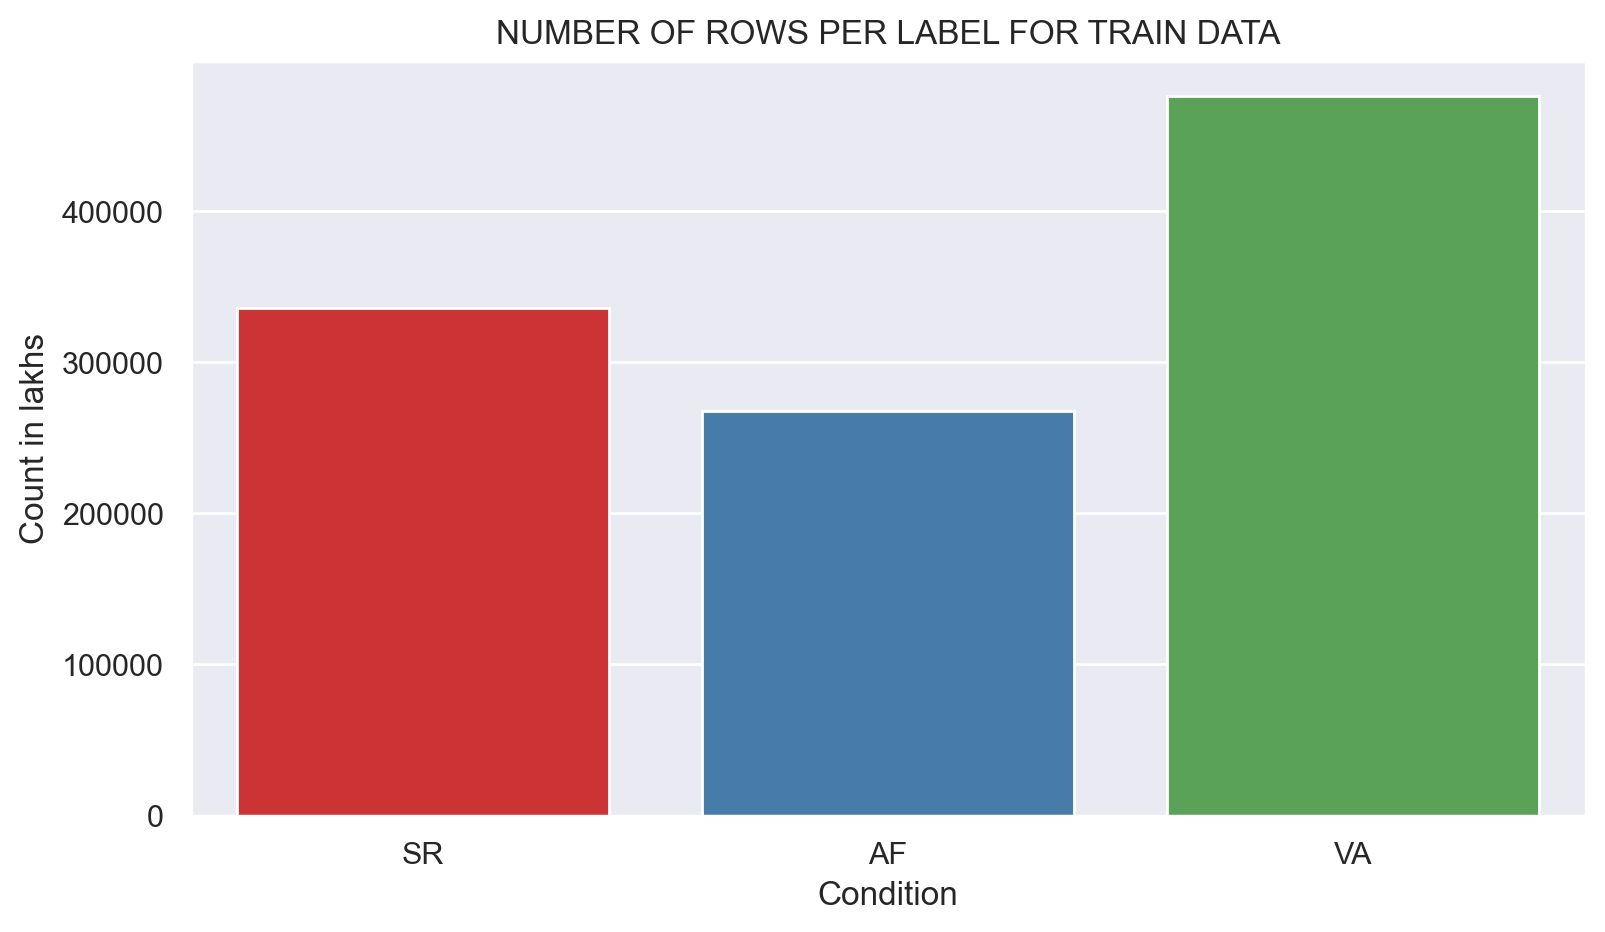

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
# countplot for diagnosi column
test = pd.DataFrame({'ritmi':list(y_test)})
sns.set(rc={'figure.figsize':(9,5),"figure.dpi":200})
g = sns.countplot(x='ritmi', data=test, palette='Set1')
g.set(xticklabels=["SR", "AF", "VA"])
plt.xlabel('Condition')
plt.ylabel('Count in lakhs')
plt.title('NUMBER OF ROWS PER LABEL FOR TRAIN DATA')
plt.show(g)

In [6]:
# KNN
# ONLY ECG features
clfl2 = KNeighborsClassifier()
parameters = {'n_neighbors': [140], 'weights': ['distance'], 'metric': ['euclidean']} #0.4830258302583026

fitmodel = GridSearchCV(clfl2, param_grid=parameters, cv=5, refit=True, scoring="accuracy", n_jobs = -1, verbose=2)
fitmodel.fit(X_train, y_train)
print(fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
KNeighborsClassifier(metric='euclidean', n_neighbors=140, weights='distance') {'metric': 'euclidean', 'n_neighbors': 140, 'weights': 'distance'} 0.751891873231041


In [ ]:
y_pred = fitmodel.predict(X_test)
print(classification_report(y_test, y_pred))

In [13]:
# Plug in appropriate max_depth and random_state parameters
import time
print(time.ctime(time.time()))
rf = RandomForestClassifier()
# rf_param_grid = {'n_estimators': [20], 'criterion': ['entropy'], 'max_depth': [20]} #0.9267653536506913
rf_param_grid = {'n_estimators': [70], 'criterion': ['entropy'], 'max_depth': [70]} #0.9868391563552115
rf_cv2= GridSearchCV(rf,rf_param_grid,cv=7,n_jobs=-1)
rf_cv2.fit(X_train,y_train)
print(time.ctime(time.time()))

print("Best Score:" + str(rf_cv2.best_score_))
print("Best Parameters: " + str(rf_cv2.best_params_))

Sun Oct 23 20:07:47 2022
Sun Oct 23 21:10:21 2022
Best Score:nan
Best Parameters: {'criterion': 'entropy', 'max_depth': 70, 'n_estimators': 70}


In [14]:
y_pred = rf_cv2.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89    335792
           1       0.90      0.84      0.87    267846
           2       0.87      0.93      0.90    476156

    accuracy                           0.89   1079794
   macro avg       0.89      0.88      0.89   1079794
weighted avg       0.89      0.89      0.89   1079794



In [16]:
import pickle as pkl
pkl.dump(rf_cv2, open('ECG_rf_better.sav', 'wb'))

In [11]:
# Plug in appropriate max_depth and random_state parameters
import time
print(time.ctime(time.time()))
rf = RandomForestClassifier()
# rf_param_grid = {'n_estimators': [20], 'criterion': ['entropy'], 'max_depth': [20]} #0.9267653536506913
rf_param_grid = {'n_estimators': [45], 'criterion': ['entropy'], 'max_depth': [20]} #0.9868391563552115
rf_cv= GridSearchCV(rf,rf_param_grid,cv=7,n_jobs=-1)
rf_cv.fit(X_train,y_train)
print(time.ctime(time.time()))

print("Best Score:" + str(rf_cv.best_score_))
print("Best Parameters: " + str(rf_cv.best_params_))

Sun Oct 23 17:58:13 2022
Sun Oct 23 18:50:43 2022
Best Score:0.8767159909262389
Best Parameters: {'criterion': 'entropy', 'max_depth': 45, 'n_estimators': 45}


# Testing

In [9]:
labels = {0:'Normal', 1:'Afib', 2:'Other'}
rf_cv.classes_

NameError: name 'rf_cv' is not defined

In [47]:
pred = rf_cv.predict([X_test.iloc[1000,:].values])[0]

print('Actual value: {} \nPredicted Value: {}'.format(labels[y_test.values[1000]],labels[pred]))

Actual value: Normal 
Predicted Value: Normal


In [53]:
y_test.shape[0]

1079794

In [30]:
y_pred = rf_cv.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99    335792
         1.0       0.98      0.98      0.98    267846
         2.0       0.99      0.99      0.99    476156

    accuracy                           0.99   1079794
   macro avg       0.99      0.99      0.99   1079794
weighted avg       0.99      0.99      0.99   1079794



In [54]:
import pickle as pkl
pkl.dump(rf_cv, open('22f_rf.sav', 'wb'))

In [163]:
import joblib
joblib.dump(rf_cv , '22rf_cv-model_jlib')

['22rf_cv-model_jlib']

## Conclusion

The third dataset, which consists of 25 features and 1 label, is the most suitable dataset to be used in training the model. Please see the below table for a summary of the prediction score among three datasets with different algorithms.

<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
</colgroup>
<thead valign="bottom">
<tr><th>Algorithms</th>
<th>(1) 11 features and 1 label</th>
<th>(2) 13 features and 1 label</th>
<th>(3) 22 features and 1 label</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>Random Forest</span></a></td>
<td>0.45 (Accuracy)</td>
<td>0.48 (Accuracy)</td>
<td>0.99 (Accuracy)</td>
</tr>
<tr><td>K-Neighbors</td>
<td>0.45 (Accuracy)</td>
<td>0.50 (Accuracy)</td>
<td>N/A</td>
</tr>
<tr><td>LightGBM</td>
<td>0.64 (AUC)</td>
<td>0.64 (AUC)</td>
<td>N/A</td>
</tr>
</tbody>
</table>

#  Model Testing using flask

In [1]:
import numpy as np
import pandas as pd
import joblib
import pickle
import time

In [56]:
s = time.time()
loaded_model = pickle.load(open("22f_rf.sav", 'rb'))
print(time.time()-s)
s = time.time()
loaded_model_jb = joblib.load("rf_cv-model_jlib")
print(time.time()-s)

4.155679702758789
2.784087657928467


In [22]:
import gzip

In [104]:
tem = pd.read_csv('data/training_13_features.csv')
tem['heart_axis'][6000:] = tem[6000:]['heart_axis'].fillna(0)
tem['pacemaker'][6000:] = tem[6000:]['pacemaker'].fillna(0)
tem[6000:].isnull().sum()

ritmi                 0
age                   0
sex                   0
height                0
weight                0
nurse                 0
site                  0
device                0
heart_axis            0
validated_by          0
second_opinion        0
validated_by_human    0
pacemaker             0
strat_fold            0
dtype: int64

In [1]:
import gzip
import numpy as np
f = gzip.GzipFile('data/compressed_npy.gz', "r")
x = np.load(f)
x.shape

(6428, 5000, 12)

In [113]:
# Saving ECG readings for testing
# read in the compressed numpy file
'''f = gzip.GzipFile('data/compressed_npy.gz', "r")
x = np.load(f)

# get 6428 layers, 700 rows and 12 columns
X = x[:,:700,:]
print(X.shape)
tem = pd.read_csv('data/training_13_features.csv')'''
ritmi = {'SR': 0, 'AF': 1, 'VA': 2}
ritmi = {v: k for k, v in ritmi.items()}
second_opi = {'False': 0, 'True':1}
second_opi = {v: k for k, v in second_opi.items()}
sex = {'Male':0, 'Female':1}
sex = {v: k for k, v in sex.items()}
val_hu = {'False': 0, 'True':1}
val_hu = {v: k for k, v in val_hu.items()}
h_axis = {'Missing':0, float('nan'):0, 'LAD':1, 'AXL':2, 'MID':3, 'RAD':4, 'ALAD':5, 'AXR':6}
h_axis = {v: k for k, v in h_axis.items()}
p_maker = {'Missing':0, 'PACE????, nan': 0, '?, nan':0, 'ja, pacemaker':1}
p_maker = {v: k for k, v in p_maker.items()}
device = {'CS100    3':0, 'CS-12': 1, 'AT-6 C 5.5':2, 'CS-12   E':3, 'AT-6     6':4, 'AT-60    3':5, 'AT-6 C 5.8':6, 'AT-6 C':7, 'AT-6 C 5.0':8, 'AT-6 C 5.3':9, 'AT-6 C 5.6':10}
device = {v: k for k, v in device.items()}
c = 0
for i in range (len(X[6000:])):
    np.save('TEST DATA/ECG/ecg_{}'.format(str(c)),X[6000:][i])
    gg = tem[6000:].loc[6000+i]
    with open('TEST DATA/PATIENT DATA/patient_data_{}.txt'.format(str(c)), 'w') as f:
        f.write('TYPE:{}\nAGE:{}\nSEX:{}\nHEIGHT:{}\nWEIGHT:{}\nDEVICE:{}\nHEART_AXIS:{}\nVALIDATED_BY:{}\nSECOND_OPINION:{}\nVAL_BY_HUMAN:{}\nPACEMAKER:{}\n'.format(
        ritmi[gg.ritmi],gg.age,sex[gg.sex],gg.height,gg.weight,device[gg.device],h_axis[gg.heart_axis],gg.validated_by,second_opi[gg.second_opinion],val_hu[gg.validated_by_human],p_maker[gg.pacemaker]
        ))
    c+=1

In [39]:
# convert 3d array to 2d array and convert it to a dataframe
m,n,r = X.shape
out_arr = np.column_stack((np.repeat(np.arange(m),n),X.reshape(m*n,-1)))
out_df = pd.DataFrame(out_arr)

In [7]:
'''
 0   I                   float64
 1   II                  float64
 2   III                 float64
 3   aVF                 float64
 4   aVR                 float64
 5   aVL                 float64
 6   V1                  float64
 7   V2                  float64
 8   V3                  float64
 9   V4                  float64
 10  V5                  float64
 11  V6                  float64
 12  ritmi               float64/
 13  age                 float64
 14  sex                 float64
 15  height              float64
 16  weight              float64
 19  device              float64
 20  heart_axis          float64
 21  validated_by        float64
 22  second_opinion      float64
 23  validated_by_human  float64
 24  pacemaker           float64
'''

ritmi = {'SR': 0, 'AF': 1, 'VA': 2}
second_opi = {False: 0, True:1}
sex = {'Male':0, 'Female':1}
val_hu = {False: 0, True:1}
h_axis = {'Missing':0, 'LAD':1, 'AXL':2, 'MID':3, 'RAD':4, 'ALAD':5, 'AXR':6}
p_maker = {'Missing':0, 'PACE????, nan': 0, '?, nan':0, 'ja, pacemaker':1}
device = {'CS100    3':0, 'CS-12': 1, 'AT-6 C 5.5':2, 'CS-12   E':3, 'AT-6     6':4, 'AT-60    3':5, 'AT-6 C 5.8':6, 'AT-6 C':7, 'AT-6 C 5.0':8, 'AT-6 C 5.3':9, 'AT-6 C 5.6':10}

inp = [ 9.80e-02,  3.90e-02, -5.90e-02, -6.80e-02,  7.90e-02, -9.00e-03,
       -2.94e-01, -1.83e-01,  3.30e-02,  3.12e-01,  2.79e-01,  3.89e-01,
        6.70e+01,  0.00e+00,  1.73e+02,  6.00e+01,  1.10e+01,  1.00e+00,
        4.00e+00,  0.00e+00,  0.00e+00,  0.00e+00,  1.00e+00,  0.00e+00,
        4.00e+00]
loaded_model.predict([inp])[0]

C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


2.0

In [116]:
X_test

,I,II,III,aVF,aVR,aVL,V1,V2,V3,V4,...,age,sex,height,weight,device,heart_axis,validated_by,second_opinion,validated_by_human,pacemaker
2051019,0.098,0.039,-0.059,-0.068,0.079,-0.009,-0.294,-0.183,0.033,0.312,...,67.0,0.0,173.000000,60.000000,4.0,0.0,0.0,0.0,1.0,0.0
3132086,-0.048,0.017,0.065,0.015,-0.057,0.041,-0.135,-0.020,0.043,0.015,...,80.0,1.0,162.000000,52.000000,2.0,0.0,2.0,0.0,1.0,0.0
21550,0.040,-0.065,-0.105,0.013,0.073,-0.085,0.165,0.076,-0.005,0.026,...,85.0,1.0,163.000000,52.000000,2.0,0.0,0.0,0.0,1.0,0.0
3678586,-0.011,0.095,0.105,-0.043,-0.058,0.100,0.045,-0.999,-0.971,-0.014,...,80.0,0.0,186.000000,78.000000,2.0,1.0,2.0,0.0,1.0,0.0
3477226,-0.020,0.025,0.045,-0.003,-0.033,0.035,0.135,-0.015,-0.015,-0.125,...,61.0,1.0,166.796356,69.841845,2.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2115086,-0.006,-0.040,-0.035,0.023,0.015,-0.037,0.000,-0.030,-0.039,-0.119,...,28.0,0.0,166.796356,69.841845,1.0,3.0,1.0,0.0,1.0,0.0
312364,0.246,0.186,-0.060,-0.215,0.152,0.063,-0.065,0.346,0.487,0.339,...,83.0,0.0,166.796356,69.841845,1.0,5.0,1.0,0.0,1.0,0.0
3104265,0.000,0.016,0.016,-0.008,-0.008,0.016,0.025,0.035,-0.005,-0.060,...,63.0,0.0,166.796356,69.841845,0.0,3.0,0.0,0.0,0.0,0.0
1395885,0.005,-0.025,-0.030,0.010,0.018,-0.027,0.050,-0.090,-0.080,-0.120,...,27.0,1.0,166.796356,69.000000,3.0,3.0,0.0,0.0,1.0,0.0


# FLASK CODE

In [117]:
X_test.columns

Index(['I', 'II', 'III', 'aVF', 'aVR', 'aVL', 'V1', 'V2', 'V3', 'V4', 'V5',
       'V6', 'age', 'sex', 'height', 'weight', 'device', 'heart_axis',
       'validated_by', 'second_opinion', 'validated_by_human', 'pacemaker'],
      dtype='object')

In [125]:
for key,value in p_maker.items():
    print('        <option value="{}">{}</option>'.format(key,value))

        <option value="0">?, nan</option>
        <option value="1">ja, pacemaker</option>


In [2]:
from flask import Flask, request, render_template
import numpy as np
import joblib,pickle
app=Flask(__name__)
xx = ['lollytest']
model = pickle.load(open("ECG_DT.pkl", 'rb'))
print('Model Loaded')
@app.route("/", methods=['GET', 'POST'])
def upload_file():
    return render_template('form.html')

@app.route("/predict", methods=['GET', 'POST'])
def scrape():
    df_name=None
    if request.method == 'POST':
        ind=request.form                  # returns an immutable dictionary
        
        l=dict(ind)
        print(l)
        print(request.files['file'])
        f = request.files['file']
        
        ecg = np.load(f)
    inp = [float(i) for i in ind.values()]
    # convert 3d array to 2d array and convert it to a dataframe
    X = ecg
    n,r = X.shape
    out_arr = np.column_stack((np.repeat(1,n),X.reshape(1*n,-1)))
    out = [0,0,0]
    num_di = {0:'SR', 1:'AF', 2:'VA'}
    for i in out_arr:
        temp=list(i[1:])
        #temp.extend(inp)
        prediction = int(model.predict([temp])[0])
        out[prediction]+=1
    prediction = num_di[out.index(max(out))]
    return render_template('out.html',p='Prediction is : '+prediction)
    
app.run()

Model Loaded
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [20/Nov/2022 15:23:35] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [20/Nov/2022 15:23:35] "GET /project/files/landingpage.css HTTP/1.1" 404 -
127.0.0.1 - - [20/Nov/2022 15:23:35] "GET /project/image/form.png HTTP/1.1" 404 -


{'age': '14', 'sex': '0', 'height': '44', 'weight': '4', 'device': '0', 'heart_axis': '0', 'validated_by': '0', 'second_opinion': '0', 'validated_by_human': '0', 'pace_maker': '0'}
<FileStorage: 'ecg_0.npy' ('application/octet-stream')>


C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with f

C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with f

C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with f

C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with f

C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with f

C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with f

C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ashwi\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with f

In [165]:
X_test

,I,II,III,aVF,aVR,aVL,V1,V2,V3,V4,...,age,sex,height,weight,device,heart_axis,validated_by,second_opinion,validated_by_human,pacemaker
2051019,0.098,0.039,-0.059,-0.068,0.079,-0.009,-0.294,-0.183,0.033,0.312,...,67.0,0.0,173.000000,60.000000,4.0,0.0,0.0,0.0,1.0,0.0
3132086,-0.048,0.017,0.065,0.015,-0.057,0.041,-0.135,-0.020,0.043,0.015,...,80.0,1.0,162.000000,52.000000,2.0,0.0,2.0,0.0,1.0,0.0
21550,0.040,-0.065,-0.105,0.013,0.073,-0.085,0.165,0.076,-0.005,0.026,...,85.0,1.0,163.000000,52.000000,2.0,0.0,0.0,0.0,1.0,0.0
3678586,-0.011,0.095,0.105,-0.043,-0.058,0.100,0.045,-0.999,-0.971,-0.014,...,80.0,0.0,186.000000,78.000000,2.0,1.0,2.0,0.0,1.0,0.0
3477226,-0.020,0.025,0.045,-0.003,-0.033,0.035,0.135,-0.015,-0.015,-0.125,...,61.0,1.0,166.796356,69.841845,2.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2115086,-0.006,-0.040,-0.035,0.023,0.015,-0.037,0.000,-0.030,-0.039,-0.119,...,28.0,0.0,166.796356,69.841845,1.0,3.0,1.0,0.0,1.0,0.0
312364,0.246,0.186,-0.060,-0.215,0.152,0.063,-0.065,0.346,0.487,0.339,...,83.0,0.0,166.796356,69.841845,1.0,5.0,1.0,0.0,1.0,0.0
3104265,0.000,0.016,0.016,-0.008,-0.008,0.016,0.025,0.035,-0.005,-0.060,...,63.0,0.0,166.796356,69.841845,0.0,3.0,0.0,0.0,0.0,0.0
1395885,0.005,-0.025,-0.030,0.010,0.018,-0.027,0.050,-0.090,-0.080,-0.120,...,27.0,1.0,166.796356,69.000000,3.0,3.0,0.0,0.0,1.0,0.0


# SGD classifier

In [ ]:
import numpy as np
from sklearn import linear_model
SGDClf = linear_model.SGDClassifier(max_iter = 1000, tol=1e-3,penalty = "elasticnet")